In [1]:
import numpy
import random
from matplotlib import pyplot as plot
from scipy import stats
from sklearn.model_selection import KFold as k_fold
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
with open("10.txt") as file:
    data = numpy.array([float(line) for line in file])

Рассматривается распределение $\Gamma(\alpha, \theta)$ с плотностью

$$p(x)=\frac{x^{\alpha-1}\theta^{\alpha}e^{-\theta x}}{\Gamma(\alpha)} I\{x>0\}$$

Оценками метов для параметров $\alpha$ и $\theta$ являются

$$\hat\alpha=\frac{\bar{X}}{\bar{X^2}-\bar{X}^2}$$ $$\hat\theta=\frac{\bar{X}^2}{\bar{X^2}-\bar{X}^2}$$

In [3]:
def square_sum(alpha, theta, data):
    data.sort()    
    return numpy.sum([
            (stats.gamma.cdf(data[i], a=theta, scale=1 / alpha) - i / len(data)) ** 2
            for i in range(len(data))
        ]
    )

def plot_cdfs(alpha, theta, data):
    continious_x = numpy.linspace(-10, 50, 1000)
    plot.plot(
        continious_x, stats.gamma.cdf(continious_x, a=theta, scale=1 / alpha),
        label="cdf by evaluated parametrs", color="red"
    )
    
    data.sort()
    plot.scatter(data, [i / len(data) for i in range(len(data))], label="empire cdf", s=5)
    plot.gca().legend(loc='lower right')

Критерий будет заключаться в определении, насколько сильно эмпирическая функция распределения отличается от реальной (сумма квадратов отклонений в точках значений выборки). Соответственно главная цель - рассчитать пороговое значения этой суммы квадратов.

Первый подход к решению задачи. Оценим параметры по всей выборке. Теперь мы получили возможность сгенерировать большое количество выборок из распределения с этими параметрами. По этим выборкам можно посчитать суммы квадратов отклонений и в качестве порогового взять, например, удвоенное среднее или максимальное значение этих отклонений (берем значения по-больше, чтобы уменьшить вероятность ошибки первого рода).

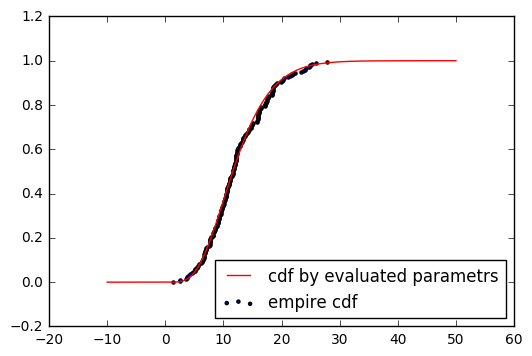

In [4]:
#  Оценили параметры
alpha = numpy.mean(data) / (numpy.mean(data ** 2) - numpy.mean(data) ** 2)
theta = numpy.mean(data) ** 2 / (numpy.mean(data ** 2) - numpy.mean(data) ** 2)

# Нарисуем картинку для наглядности.
plot_cdfs(alpha, theta, data)

In [5]:
N = 1000
bootstrap_size = 1000

# Сгенерировали выборки с этими параметрами и посчитали отклонения
samples = [stats.gamma.rvs(a=theta, scale=1 / alpha, size=N) for i in range(bootstrap_size)]
square_sums = [square_sum(alpha, theta, sample) for sample in samples]

In [6]:
# Посмотрим на распределения значения отклонений чтобы сравнить его с отклонением на выборке
print("min: {}, max: {}, mean: {}".format(numpy.min(square_sums), numpy.max(square_sums), numpy.mean(square_sums)))

min: 0.01630912601555759, max: 1.4063606525257226, mean: 0.16368447560587412


In [7]:
# Считаем отклонение на выборке
print("test value: {}".format(square_sum(alpha, theta, data)))

test value: 0.049356859487077624


Видно, что какое бы разумное значение порога мы не взяли, значение на выборке получится меньше его, а значит можно считать, что гипотеза по принадлежности к нашему распределению верна.

Второй подход к решению заключается в следующем. Разделим выборку на 2 части. В первую будем использовать для оценки порогового значения, а вторую для проверки гипотезы.

In [8]:
# Разделяем данные на обучающие и тестовые. Для тестов при этом оставим треть выборки.
train_data, test_data = train_test_split(data, test_size = (1 / 3))

In [9]:
# Снова оцениваем параметры. Теперь по обучающей части выборки.
train_alpha = numpy.mean(train_data) / (numpy.mean(train_data ** 2) - numpy.mean(train_data) ** 2)
train_theta = numpy.mean(train_data) ** 2 / (numpy.mean(train_data ** 2) - numpy.mean(train_data) ** 2)

# А теперь сравним как изменились эти оценки
print("alpha={}, train_alpha={}, theta={}, train_theta={}".format(alpha, train_alpha, theta, train_theta))

alpha=0.4500347731567252, train_alpha=0.46719060333424506, theta=5.556493837559186, train_theta=5.665135692474539


Оценки не очень сильно изменились. Будем использовать оценки по обучающей части выборки.

In [10]:
# С помощью функции sklearn'а генерируем выборки из обучающей части.
# при этом делаем их размер такой же, как у тестирующей части выборки.
train_data_samples = [
    train_test_split(train_data, test_size = 0.5)[0]
    for i in range(bootstrap_size)
]
train_data_square_sums = [square_sum(train_alpha, train_theta, sample) for sample in train_data_samples]

In [11]:
# Опять смотрим на распределения значения отклонений
print("min: {}, max: {}, mean: {}".format(
        numpy.min(train_data_square_sums), numpy.max(train_data_square_sums), numpy.mean(train_data_square_sums)
    )
)

min: 0.014685073928130257, max: 0.8055784393914094, mean: 0.11424562361213907


In [12]:
# И на знаачение отклонения на тестовой выборке
print(square_sum(train_alpha, train_theta, test_data))

0.152052704049


Заключение осталось таким же (выбираем порог равный удвоенному среднему или макимальному значению отклонения). Только изменилось значение порога. Идейная проблема второго метода в том, что вслучае, если гипотеза на самом деле не верна, оценка порога по частям выборки могла бы быть неверной. Впрочем для неверной гипотезы не обязаны хорошо работать даже оценки параметров. Поэтому в целом методы равносильны.